### Importing the essential libraries

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import time

# For model Training 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

### Read the data 

In [2]:
df = pd.read_csv('train.csv')
df

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,8405,107.39,ak,s,as,c,d,aa,d,q,...,1,0,0,0,0,0,0,0,0,0
4205,8406,108.77,j,o,t,d,d,aa,h,h,...,0,1,0,0,0,0,0,0,0,0
4206,8412,109.22,ak,v,r,a,d,aa,g,e,...,0,0,1,0,0,0,0,0,0,0
4207,8415,87.48,al,r,e,f,d,aa,l,u,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# To check the datatypes of the variables in the dataset
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ['Count', 'Column_Type']
dtype_df.groupby('Column_Type').aggregate('count').reset_index()

,Column_Type,Count
0,int64,369
1,float64,1
2,object,8


In [4]:
# To find missing values in dataset which has a huge number of rows
missing_df = df.isnull().sum(axis = 0).reset_index()
missing_df.columns = ['Column_name', 'Missing_count']
missing_df = missing_df.loc[missing_df['Missing_count']>0]
missing_df = missing_df.sort_values(by = 'Missing_count')
missing_df

# We can see that there are no columns that have any missing values in the dataset

,Column_name,Missing_count


In [5]:
# To check if there are any duplicate rows
isdup = df.duplicated().sum().any()

if isdup == True:
    print("There are duplicate rows in the dataset")
else:
    print("There are no duplicate rows in the dataset")

There are no duplicate rows in the dataset


### Analysis of the dependent variable

## Here y is the target variable which is the amount of time spent by a car in the test bench

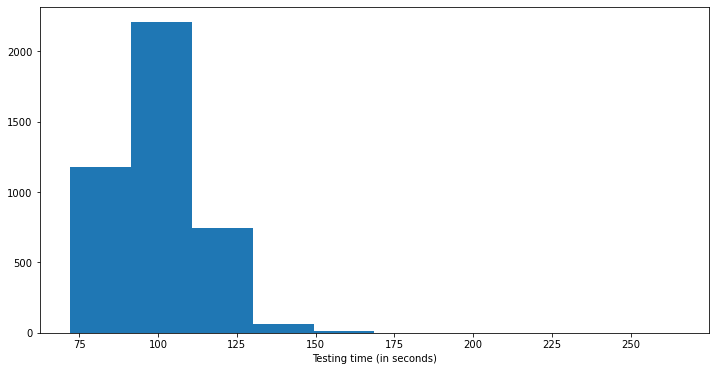

In [6]:
y_train = df['y'].values
plt.figure(figsize = (12,6))
plt.hist(y_train, bins = 10)
plt.xlabel('Testing time (in seconds)')
plt.show()

Text(0, 0.5, 'Testing time')

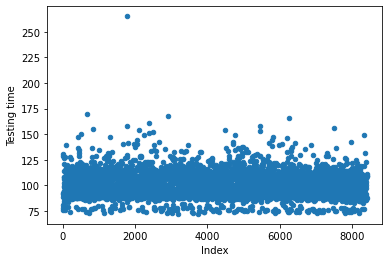

In [7]:
# Now using scatter plot to check the distribution

df.plot.scatter(x = 'ID', y = 'y')
plt.xlabel('Index')
plt.ylabel('Testing time')

#### From the above two plots we can see that most of the points belong from 0 to 150 seconds. Here we can see one point which seems to be taking more than 250 secs. Maybe this car is rarely bought and also is an expensive car, thus only one such data point is available here. We can consider this point as an outlier. 

<AxesSubplot:>

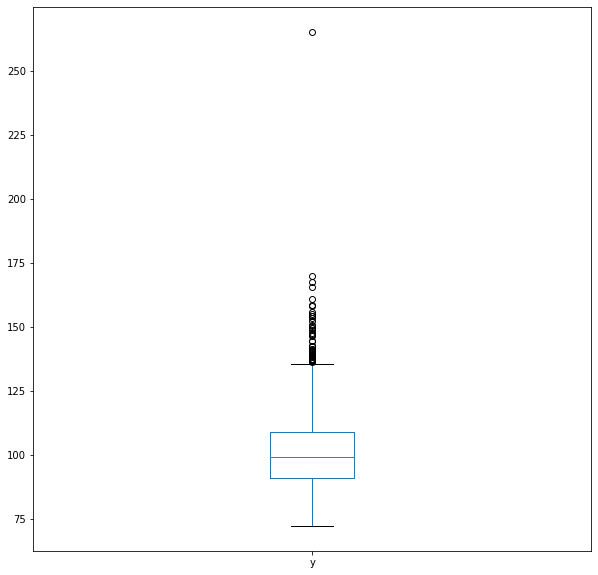

In [8]:
plt.figure(figsize = (10,10))
df['y'].plot(kind = 'box')

In [9]:
# Outlier treatment
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3-Q1
cutoff = IQR*1.5
lower = Q1-cutoff
upper = Q3+cutoff

In [10]:
df = df[(df['y']>=lower)&(df['y']<=upper)]

## Using Boxplot to visualize the variance of the columns

In [11]:
# As we checked previously there are 8 categorical variables in the dataset
cat_cols = df.select_dtypes(['object']).columns.tolist()
cat_cols

['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']

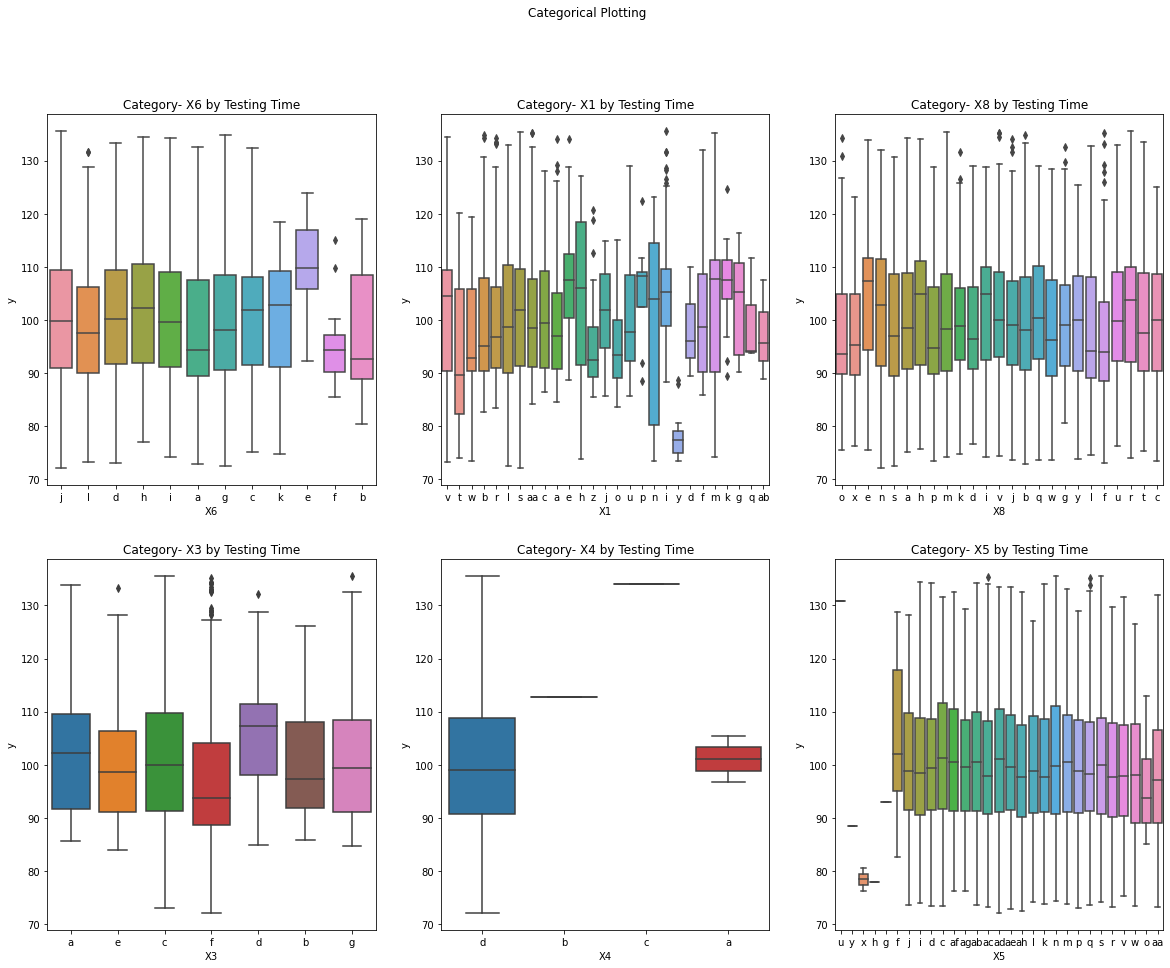

In [12]:
plt.figure(figsize = (20,15))
plt.subplot(2,3,1)
plt.title('Category- X6 by Testing Time') 
sns.boxplot(x="X6", y="y", data = df)
plt.subplot(2,3,2)
plt.title('Category- X1 by Testing Time')
sns.boxplot(x="X1", y="y", data = df)
plt.subplot(2,3,3)
plt.title('Category- X8 by Testing Time')
sns.boxplot(x="X8", y="y", data = df)
plt.subplot(2,3,4)
plt.title('Category- X3 by Testing Time')
sns.boxplot(x="X3", y="y", data = df)
plt.subplot(2,3,5)
plt.title('Category- X4 by Testing Time')
sns.boxplot(x="X4", y="y", data = df)
plt.subplot(2,3,6)
plt.title('Category- X5 by Testing Time')
sns.boxplot(x="X5", y="y", data = df)
plt.suptitle('Categorical Plotting')
plt.show()

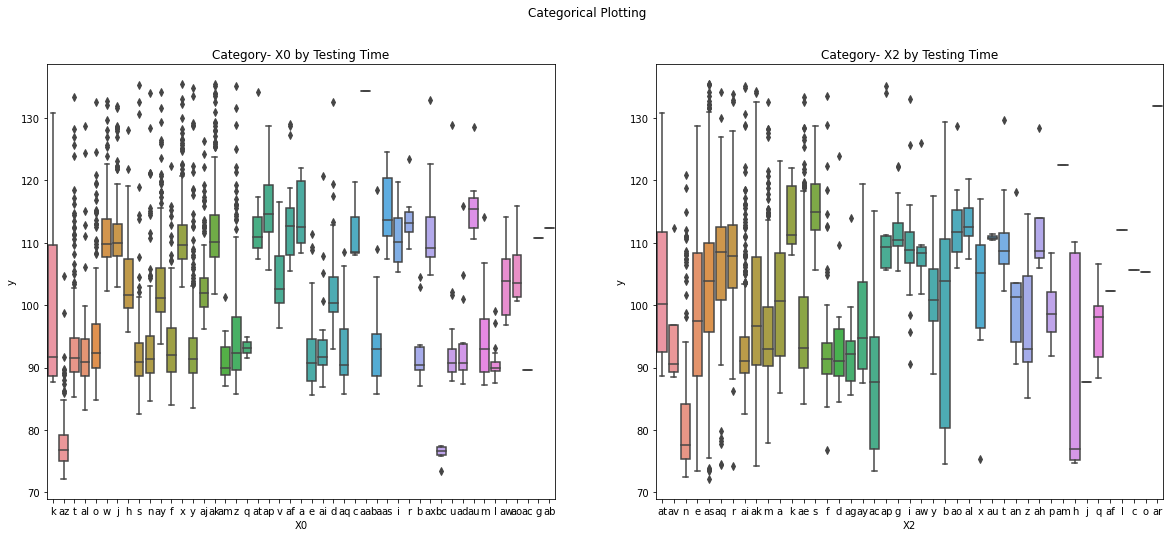

In [13]:
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.title('Category- X0 by Testing Time')
sns.boxplot(x="X0", y="y", data = df)
plt.subplot(1,2,2)
plt.title('Category- X2 by Testing Time')
sns.boxplot(x="X2", y="y", data = df)
plt.suptitle('Categorical Plotting')
plt.show()

#### We can see that feature X4 must have the lowest among the other categorical features hence we can go ahead and drop the X4 feature. 

#### We wil also go ahead and split our data further into X and Y where 

In [14]:
X = df.drop(['ID','y'], axis = 1)
Y = df['y']

In [15]:
X = X.drop(['X4'], axis = 1)

## Analysis of Binary Features

In [16]:
X_binary = X.drop(['X0', 'X1', 'X2', 'X3', 'X5', 'X6', 'X8'], axis = 1)

#### We use the variance threshold to find the binary columns with zero variance

In [17]:
# Using the variance threshold method
from sklearn.feature_selection import VarianceThreshold
var_thres = VarianceThreshold(threshold = 0)
var_thres.fit(X_binary)

VarianceThreshold(threshold=0)

In [18]:
constant_cols = [column for column in X_binary.columns
                if column not in X_binary.columns[var_thres.get_support()]]
print(len(constant_cols))

13


In [19]:
# Features with zero variance
for i in constant_cols:
    print(i)

X11
X93
X107
X233
X235
X268
X289
X290
X293
X297
X330
X339
X347


In [20]:
# We can go ahead and drop the above columns since they will not contribute much to the prediction of Testing time
X = X.drop(['X11','X93','X107','X233','X235','X268','X289','X290','X293','X297','X330','X339','X347'], axis = 1)

## Encoding the categorical columns

In [21]:
from sklearn.preprocessing import LabelEncoder
cat_cols = X.select_dtypes(['object']).columns.tolist()
cat_cols

['X0', 'X1', 'X2', 'X3', 'X5', 'X6', 'X8']

In [22]:
LE = LabelEncoder()
for i in cat_cols:
    X[i] = LE.fit_transform(X[i])

## Splitting the data for training purposes

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 1)
print("Shapes: ", X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

Shapes:  (2911, 362) (1248, 362) (2911,) (1248,)


# Training the model with different classification algorithms

## 1- Random Forest Model

In [24]:
start_time = time.time()
rf_model = RandomForestRegressor()
rf_model.fit(X_train,Y_train)
fit_time = time.time() - start_time
print("Time consumed to fit model: ",time.strftime("%H:%M:%S", time.gmtime(fit_time)))
rf_model.score(X_train,Y_train)
rf_model.score(X_test,Y_test)

Time consumed to fit model:  00:00:05


0.602398708717103

In [ ]:
param_grid = {
    'min_samples_leaf':[1,2,4],
    'n_estimators':[250,500,1000],
    'max_depth':[3,5,7,9,11]
}
grid = GridSearchCV(rf_model, param_grid=param_grid, cv = 3, verbose = 10, n_jobs = 1)
grid.fit(X_train, Y_train)
grid.best_params_
grid.best_score_

## 2- Gradient Boost Model

In [26]:
# Gradient Boost
start_time = time.time()
GB = GradientBoostingRegressor()
GB.fit(X_train, Y_train)
fit_time = time.time() - start_time
print("Time consumed to fit model: ",time.strftime("%H:%M:%S", time.gmtime(fit_time)))
print('The score on the train dataset is: ',GB.score(X_train,Y_train))
print('The score on the test dataset is: ',GB.score(X_test,Y_test))

Time consumed to fit model:  00:00:01
The score on the train dataset is:  0.6960617460889884
The score on the test dataset is:  0.6529969629532218


In [ ]:
parameters = {
    "n_estimators":[500,750,1000],
    "max_depth":[1,3,5],
    "learning_rate":[0.001,0.01,1]
}
grid = GridSearchCV(GB, param_grid=parameters, cv = 3, verbose = 2)
grid.fit(X_train, Y_train)
grid.best_params_
grid.best_score_

<AxesSubplot:xlabel='y', ylabel='Density'>

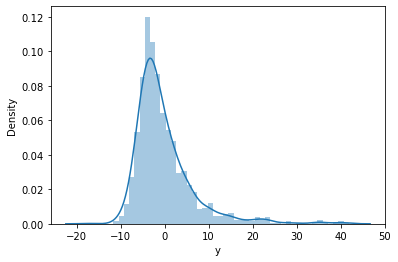

In [27]:
predictions = GB.predict(X_test)
sns.distplot(Y_test-predictions)

## 3- XGBoost Model

In [24]:
xgbModel=XGBRegressor(max_depth=3, min_child_weight=4, reg_lambda=1000, gamma = 100)

In [25]:
xgbModel.fit(X_train,Y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=100, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1000, ...)

In [26]:
xgbModel.score(X_train,Y_train)

0.65189169310899

In [27]:
xgbModel.score(X_test,Y_test)

0.6466983194549232

In [28]:
predictions = xgbModel.predict(X_test)

In [29]:
predictions

array([ 94.205894,  95.619125, 110.81419 , ..., 110.33333 ,  95.619125,
       111.39734 ], dtype=float32)

<AxesSubplot:xlabel='y', ylabel='Density'>

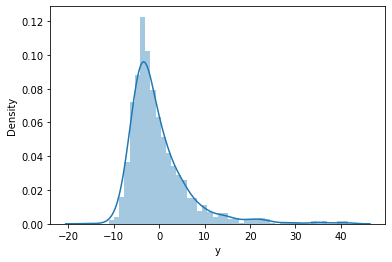

In [30]:
sns.distplot(Y_test-predictions)